скачаем подготовленный в supervise.ly датасет ключей

### загрузка датасета

In [ ]:
torch.save(unet_model.state_dict(), '/kaggle/working/512_3unet_60ep.pth')

In [ ]:
cd /kaggle/working/

In [ ]:
from IPython.display import FileLink
#FileLink(r'/kaggle/working/1024_3unet_50ep.pth')
FileLink(r'512_3unet_150ep.pth')

In [ ]:
%cd /kaggle/working/
!pip uninstall gdown -y && pip install gdown
dataset_link = 'https://drive.google.com/uc?id=1iOTwWT8jqoAR2HVla4KdXl2ML7KzpB9a'
!mkdir key_seg
!gdown {dataset_link} -O /kaggle/working/key_seg/dataset.tar
%cd /kaggle/working/key_seg/
!tar -xvf dataset.tar

In [ ]:
#скачать модельку

model_url = 'https://drive.google.com/uc?id=1jpvu90mPW801GVhYRWsPjGcCXZDxAHrs' # 512_1
model_url = 'https://drive.google.com/uc?id=1ZqubEuS9WnymsyVtbR_Or_VxA7cpACMJ' # 1024_3
model_url = 'https://drive.google.com/uc?id=1rpZseHIDv_k5kAmZz-mxH2q0JsNv4qOV' # 512_3
!gdown {model_url} -O /kaggle/working/key_seg/model.pth

In [ ]:
core_path = '/kaggle/working/key_seg/ds0/'

import glob
img = sorted(glob.glob(f"{core_path}img/*"))
mask = sorted(glob.glob(f"{core_path}masks_machine/*.png"))
ann = sorted(glob.glob(f"{core_path}ann/*.json"))

В ходе разметки плохие изображения помечались тэгом bad image, изображения среднего качества помечались тэгом mid_quality image

Изображения имеют разные размеры. Давайте изменим их размер на $1024\times1024 $ пикселей. Для изменения размера изображений, будем дополнять их черными линиями, не растягивая. Высота у изображений всегда 1024.


# через pytorch dataset грузим

In [ ]:
#фильтруем файлы основываясь на аннотациях
from PIL import Image
import numpy as np

dataset = {'good' : {'mask' :[], 'img': []}, 'mid' : {'mask' :[], 'img': []}}

import json 
for ind, f_ann in enumerate(ann):
    data = json.load(open(f_ann))
    if data['tags']:
        if data['tags'][0]['name'] == 'bad image':
            continue
        if data['tags'][0]['name'] == 'mid_quality image':
            dataset['mid']['mask'].append(mask[ind])
            dataset['mid']['img'].append(img[ind])
            continue
    else:
        if data['objects'][0]['tags']:
            if data['objects'][0]['tags'][0]['name'] == 'bad image':
                continue
            if data['objects'][0]['tags'][0]['name'] == 'mid_quality image':
                dataset['mid']['mask'].append(mask[ind])
                dataset['mid']['img'].append(img[ind])
                continue
        
    dataset['good']['mask'].append(mask[ind])
    dataset['good']['img'].append(img[ind])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch import Tensor
import random


from matplotlib import rcParams
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# в ходе экспериментов пробовал различные размеры, начинал с маленьких, но кажется, что чем больше информации - тем лучше, так что лучше не сжимать
# аналогичная история с каналами, начинал с 1 канальных изображений, но решил оставить 3 канальные входные
RESCALE_SIZE = 1024 #попробовать 1024
CROP = 20

class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return TF.pad(image, padding, 0, 'constant')
  
class RandomRotation(transforms.RandomRotation):
    def __init__(self, *args, **kwargs):
        super(RandomRotation, self).__init__(*args, **kwargs) # let super do all the work

        self.angle = self.get_params(self.degrees) # initialize your random parameters

    def forward(self, img): # override T.RandomRotation's forward
        fill = self.fill
        if isinstance(img, Tensor):
            if isinstance(fill, (int, float)):
                fill = [float(fill)] * TF.get_image_num_channels(img)
            else:
                fill = [float(f) for f in fill]

        return TF.rotate(img, self.angle, self.resample, self.expand, self.center, fill)

class FilteredKeySegDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic happens like transform

         self.image_paths = image_paths
         self.target_paths = target_paths
            
    def transform(self, image, mask):
        
        img_w, img_h = image.size
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(img_h - CROP, img_w - CROP))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        common_transform = transforms.Compose([
                    SquarePad(),
                    transforms.ToTensor(),            
                    transforms.Resize([RESCALE_SIZE, RESCALE_SIZE]),
                    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    #transforms.Grayscale(num_output_channels=1),
                    #transforms.RandAugment(),
                    #transforms.RandomHorizontalFlip(p=0.5),
                ])
        
        image_only_transform = transforms.Compose([
                    #transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    transforms.RandomAdjustSharpness(sharpness_factor=2),
                    #transforms.RandomAutocontrast(),
                    #transforms.RandomEqualize(),
        ]) 
        
        mask_only_transform = transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
        ])

        #image = image_only_transform(image)
        mask = mask_only_transform(mask)
        
        image = common_transform(image)
        mask = common_transform(mask)
        
        #image = image_only_transform(image)
        
        mask = mask > 0
        #mask = mask + 1
        #mask = mask - mask.min()
        #mask = mask / (mask.max() - mask.min())

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation
        rotate = RandomRotation(degrees=10)
        image = rotate(image)
        mask = rotate(mask)

        #image = image_only_transform(image)
        # Transform to tensor
        #image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask)        

        return image, mask

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image, t_mask = self.transform(image, mask)
        return t_image, t_mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)

* только с резкостью норм
* пробую без всего - не очен
* еще бы потом попробовать с лосом дайс просто - с дайсом попробовал 20 эпох - хреново, надо попробовать 40

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

batch_size = 1

train_photos, val_photos, train_labels, val_labels = train_test_split(dataset['good']['img'], dataset['good']['mask'], train_size=0.8)

train_dataset = FilteredKeySegDataset(train_photos, train_labels)
val_dataset = FilteredKeySegDataset(val_photos, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18*6))
for i in range(6):
    random_img = int(np.random.uniform(0,len(train_dataset) - 1))
    im_train, label = train_dataset[random_img]
    plt.subplot(6, 1, i+1)
    plt.axis("off")
    plt.imshow(im_train[0], cmap='gray')
    plt.imshow(label[0], cmap='jet', alpha=0.2)
    
plt.show();

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(6):
    random_img = int(np.random.uniform(0,len(train_dataset) - 1))
    im_train, label = train_dataset[random_img]
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(im_train[0])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(label[0])
plt.show();

In [ ]:
#добавил второе слагаемое, которое уменьшается, если ground_truth меньше чем область prediction_mask  - это важно, маски больше изначальной должны штрафоваться сильнее
def iou_pytorch_balanced(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = (outputs.squeeze(1) > 0.5).byte()
    labels = labels.squeeze(1).byte()
    
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = 1/2 * ((intersection + SMOOTH) / (union + SMOOTH) + (intersection + SMOOTH) / (labels.float().sum((1, 2)) + SMOOTH))  # We smooth our devision to avoid 0/0
    return iou

## Тренировка

In [ ]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, vis = False):
    loaders = {"train": data_tr, "valid": data_val}
    accuracies = {'loss' : {'train' : [],
                            'valid' : []},
                  
                  'score' : {'train' : [],
                            'valid' : []},
                  'time' : {'train' : [],
                            'valid' : []},
                }
    for epoch in range(epochs):        
        print('* Epoch %d/%d' % (epoch+1, epochs))
        for k, dataloader in loaders.items():
            tic = time()
            avg_loss = 0
            model.train()  # train mode
            for X_batch, Y_batch in dataloader:            
                # data to device
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                if k == "train":
                    # set parameter gradients to zero
                    optimizer.zero_grad()

                    # forward
                    Y_pred = model(X_batch)
                    loss =  loss_fn(Y_batch, Y_pred)
                    loss.backward()

                    # update weights
                    optimizer.step()

                    # calculate loss to show the user
                    avg_loss += loss / len(data_tr)                 
                else:
                    model.eval()
                    with torch.no_grad():
                        Y_pred = model(X_batch)
                        loss =  loss_fn(Y_batch, Y_pred)
                        avg_loss += loss / len(data_tr)
            toc = time()
            accuracies['loss'][k].append(avg_loss.detach().cpu().numpy())
            accuracies['score'][k].append(score_model(model, iou_pytorch_balanced, dataloader))
            accuracies['time'][k].append(toc-tic)
    
            #del Y_pred, Y_batch, X_batch
            #torch.cuda.memory.empty_cache()    

        if vis:
        # show intermediate results        
            model.eval()  # testing mode
            Y_hat = Y_pred.detach().cpu()# detach and put into cpu
            X_hat = X_batch.detach().cpu().numpy()
            Y_real = Y_batch.detach().cpu()# detach and put into cpu
            
            # Visualize tools
            clear_output(wait=True)
            for k in range(3):
                plt.subplot(3, 3, k+1)
                plt.imshow(X_hat[k, 0], cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 3, k+4)
                plt.imshow(Y_real[k, 0], cmap='gray')
                plt.title('Label')
                plt.axis('off')
                
                plt.subplot(3, 3, k+7)
                Y_hat[k, 0][Y_hat[k, 0]<0.5]=0
                Y_hat[k, 0][Y_hat[k, 0]>0.5]=1
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            del Y_pred, Y_batch, X_batch, Y_hat, X_hat
            torch.cuda.memory.empty_cache()        
            plt.show()

        print(f"score val/train - {accuracies['score']['valid'][-1]}/{accuracies['score']['train'][-1]}, val/train loss - {accuracies['loss']['valid'][-1]}/{accuracies['loss']['train'][-1]}")        

    return accuracies
        

## Инференс

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        #Y_pred = torch.sigmoid(model(X_batch))
        Y_pred = model(X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

        del Y_pred, Y_label, X_batch
        torch.cuda.memory.empty_cache()

    return scores/len(data)

-----------------------------------------------------------------------------------------

# U-Net

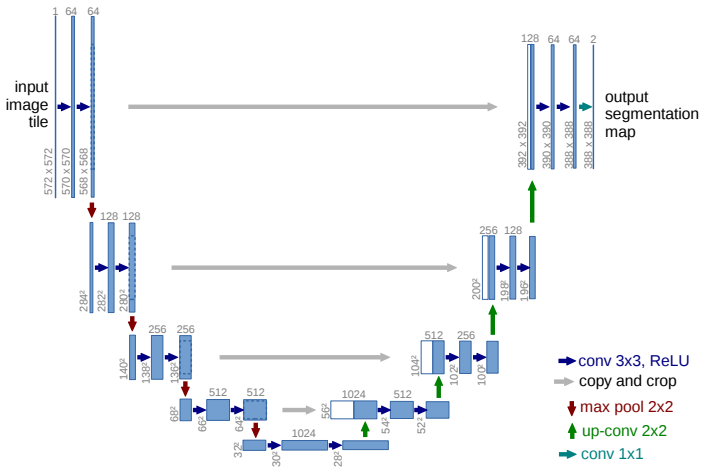

In [ ]:
class UNet(nn.Module):
    batchNorm_momentum = 0.1
    def __init__(self):
        super().__init__()

        self.enc_conv0 = self.make_enc_layer(3, 64)
        self.enc_conv1 = self.make_enc_layer(64, 128)
        self.enc_conv2 = self.make_enc_layer(128, 256)
        self.enc_conv3 = self.make_enc_layer(256, 512)

        self.bridge = nn.Sequential(
                nn.Conv2d(512,1024,kernel_size = 3, padding = 1),
                nn.BatchNorm2d(1024, momentum= self.batchNorm_momentum),
                nn.ReLU(),
                nn.Conv2d(1024,1024,kernel_size = 3, padding = 1),
                nn.BatchNorm2d(1024, momentum= self.batchNorm_momentum),
                nn.ReLU(),
            )
        
        self.dec_conv0 = self.make_dec_layer(1024 + 512, 512)
        self.dec_conv1 = self.make_dec_layer(512 + 256, 256)
        self.dec_conv2 = self.make_dec_layer(256 + 128, 128)
        self.dec_conv3 = self.make_dec_layer(128 + 64, 64)

        self.exit = nn.Conv2d(64,1,kernel_size = 1, padding = 0)

        self.upsample = nn.Upsample(scale_factor=2)

    def make_enc_layer(self, input, output):
        return nn.Sequential(
            nn.Conv2d(input,output,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(output, momentum= self.batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(output,output,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(output, momentum= self.batchNorm_momentum),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
    def make_dec_layer(self, input, output):
        return nn.Sequential(
            nn.Conv2d(input,output,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(output, momentum= self.batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(output,output,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(output, momentum= self.batchNorm_momentum),
            nn.ReLU(),
        )        

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        
        bridge = self.bridge(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample(torch.cat([bridge, e3], dim=1)))
        d1 = self.dec_conv1(self.upsample(torch.cat([d0, e2], dim=1)))
        d2 = self.dec_conv2(self.upsample(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(self.upsample(torch.cat([d2, e0], dim=1)))
        
        return self.exit(d3)

In [ ]:
unet_model = UNet().to(device)

In [ ]:
# просмотр уровней и названий сетки
for name, layer in net2.named_modules():
    print(name)
    pass

In [ ]:
#попробовать претрейнед юнет
net2 = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=1)

#меняем вход
net2.inc.double_conv[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

#меняем выход
net2.outc = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
from torchsummary import summary
summary(unet_model, input_size = (1,512,512), batch_size = 8)

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred).view(-1)
    y_real = y_real.view(-1)
    smooth = 1e-8
    intersection = (y_real * y_pred).sum()                            
    dice = (2.*intersection + smooth)/(y_pred.sum() + y_real.sum() + smooth)  
    return 1 - dice

def focal_loss(y_real, y_pred):
    eps = 1e-8
    gamma = 2
    alpha = 0.25
    bce_loss_val = bce_loss(y_real, y_pred)
    p_t = torch.exp(-bce_loss_val)
    alpha_tensor = (1 - alpha) + y_real * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss_val
    return f_loss.mean()


In [ ]:
def bnd_dice_loss(y_pred, y_real):  
    theta0=3
    theta=5
    n = batch_size        
    pred = torch.sigmoid(y_pred)
        
    one_hot_gt = y_real.float()

    # boundary map
    gt_b = F.max_pool2d(1 - one_hot_gt, kernel_size=theta0, stride=1, padding=(theta0 - 1) // 2)
    gt_b -= 1 - one_hot_gt

    pred_b = F.max_pool2d(
        1 - pred, kernel_size=theta0, stride=1, padding=(theta0 - 1) // 2)
    pred_b -= 1 - pred

    # extended boundary map
    gt_b_ext = F.max_pool2d(
        gt_b, kernel_size=theta, stride=1, padding=(theta - 1) // 2)

    pred_b_ext = F.max_pool2d(
        pred_b, kernel_size=theta, stride=1, padding=(theta - 1) // 2)

    # reshape
    gt_b = gt_b.view(n, 1, -1)
    pred_b = pred_b.view(n, 1, -1)
    gt_b_ext = gt_b_ext.view(n, 1, -1)
    pred_b_ext = pred_b_ext.view(n, 1, -1)

    # Precision, Recall
    P = torch.sum(pred_b * gt_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
    R = torch.sum(pred_b_ext * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

    # Boundary F1 Score
    BF1 = 2 * P * R / (P + R + 1e-7)

    # summing BF1 Score for each class and average over mini-batch
    bnd_loss = torch.mean(1 - BF1)

    return bnd_loss + dice_loss(y_pred, y_real)

Попробовал лосы выше, на первый взгляд dice самый удачный, но по смыслу нам в первую очередь важно совпадение границ - поэтому добавим в dice boundary loss

In [ ]:
model = UNet()
model.load_state_dict(torch.load('/kaggle/working/key_seg/model.pth'))
unet_model = model.to(device)

In [ ]:
data = train(unet_model, optim.Adam(unet_model.parameters(), lr = 3e-4), bnd_dice_loss, 100, train_loader, val_loader, vis = False)

In [ ]:
data = train(unet_model, optim.Adam(unet_model.parameters(), lr = 3e-4), bnd_dice_loss, 10, train_loader, val_loader, vis = False)

In [ ]:
data = train(unet_model, optim.Adam(unet_model.parameters(), lr = 3e-4), bnd_dice_loss, 20, train_loader, val_loader, vis = False)

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import pandas as pd
import pickle
import subprocess
import re

def plot_learning_process(models, losses, data_type, score_name, data):        
    sns.set(style="dark", font_scale=1)
    fig, ax = plt.subplots(figsize=(15, 10))
    
    #for model_name, loss_name in itertools.product(models, losses):
    #ax = all_axes[losses.index(loss_name), models.index(model_name)]
    axes = [ax, ax.twinx()]
    for ax, score in zip(axes, score_name):
        for dt in data_type:
            ax.plot(range(len(data[score][dt])), data[score][dt])
        ax.set_ylabel(f'{score}')
    axes[0].set_xlabel('Epochs')
    
    lines = ax.get_lines()
    fig.legend(lines, data_type, loc = 'upper center', fontsize = 'x-large', ncol = len(data_type))
    plt.show()


In [ ]:
data_type = ['train', 'valid']
score_name = ('score', 'loss')


plot_learning_process(unet_model, bce_loss, data_type, score_name, data)

In [ ]:
unet_model.eval()

X_batch, Y_batch  = iter(train_loader).next()
X_batch = X_batch.to(device)
Y_batch = Y_batch.to(device)
Y_pred = unet_model(X_batch)

Y_hat = Y_pred.detach().cpu()
X_hat = X_batch.detach().cpu().numpy()

Y_hat_l = Y_batch.detach().cpu().numpy()


plt.figure(figsize=(30,15))

for k in range(4):
    plt.subplot(2, 4, k+1)
    #plt.imshow(np.moveaxis(X_hat[k], 0, 2), cmap='gray')
    plt.imshow(X_hat[k, 0], cmap='gray')
    plt.title('prediction')
    plt.axis('off')

    Y_hat[k, 0][Y_hat[k, 0]<0.5]=0
    Y_hat[k, 0][Y_hat[k, 0]>0.5]=1

    # добавить прозрачную маску на ту же картинку
    plt.imshow(Y_hat[k, 0], cmap='jet', alpha=0.4) # interpolation='none'

    plt.subplot(2, 4, k+5)
    plt.imshow(X_hat[k, 0], cmap='gray')
    plt.imshow(Y_hat_l[k, 0], cmap='jet', alpha=0.4)
    plt.title('label')
    plt.axis('off')


In [ ]:
label[0].moveaxis(0,2).shape

In [ ]:
unet_model = unet_model.to(device)
unet_model.eval()

In [ ]:
im_train.unsqueeze(0).shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(30, 15))
for i in range(4):
    random_img = int(np.random.uniform(0,len(val_dataset) - 1))
    im_train, label = val_dataset[random_img]
    im_train = im_train.unsqueeze(0)
    label = label.unsqueeze(0)
    
    #im_train, label  = iter(val_loader).next()
    label_pred = unet_model(im_train.to(device))
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(im_train[0].moveaxis(0,2).cpu().detach().numpy(), cmap='gray')    
    plt.title('prediction')
    
    label_pred[label_pred<0.5]=0
    label_pred[label_pred>0.5]=1

    # добавить прозрачную маску на ту же картинку
    plt.imshow(label_pred[0].moveaxis(0,2).cpu().detach().numpy(), cmap='jet', alpha=0.4) # interpolation='none'
    
    plt.subplot(2, 4, i+5)
    plt.axis("off")
    plt.imshow(im_train[0].moveaxis(0,2).cpu().detach().numpy(), cmap='gray')    
    plt.title('original')
    plt.imshow(label[0].moveaxis(0,2).cpu().detach().numpy(), cmap='jet', alpha=0.4) # interpolation='none'
        
plt.show();

In [ ]:
ls

In [ ]:
torch.save(unet_model.state_dict(), '/kaggle/working/512_3unet_150ep.pth')

In [ ]:
model = UNet()
model.load_state_dict(torch.load('/kaggle/working/key_seg/model.pth'))